### Imports

In [283]:
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
import time

### Obtain and Prepare Data

In [284]:
start = datetime.strptime('2020-01-02','%Y-%m-%d')
end = datetime.strptime('2022-02-28','%Y-%m-%d')

df = data.DataReader('^HSI',start=start, end=end, data_source='yahoo')
df = df[:1500]['Close']

In [285]:
scaler=MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(np.array(df).reshape(-1,1))

In [286]:
training_size=int(len(data)*0.65)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:]

In [287]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [288]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [289]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

### Reservoir Implementation

In [290]:
class Reservoir(object):
    """
    Build a reservoir and evaluate internal states
    
    Parameters:
        n_internal_units = processing units in the reservoir
        spectral_radius = largest eigenvalue of the reservoir matrix of connection weights
        leak = amount of leakage in the reservoir state update (optional)
        connectivity = percentage of nonzero connection weights (unused in circle reservoir)
        input_scaling = scaling of the input connection weights
        noise_level = deviation of the Gaussian noise injected in the state update
        circle = generate determinisitc reservoir with circle topology
    """
    
    def __init__(self, n_internal_units=100, spectral_radius=0.99, leak=None,
                 connectivity=0.3, input_scaling=0.2, noise_level=0.01, circle=False):
        
        # Initialize attributes
        self._n_internal_units = n_internal_units
        self._input_scaling = input_scaling
        self._noise_level = noise_level
        self._leak = leak

        # Input weights depend on input size: they are set when data is provided
        self._input_weights = None

        # Generate internal weights
        if circle:
            self._internal_weights = self._initialize_internal_weights_Circ(
                    n_internal_units,
                    spectral_radius)
        else:
            self._internal_weights = self._initialize_internal_weights(
                n_internal_units,
                connectivity,
                spectral_radius)


    def _initialize_internal_weights_Circ(self, n_internal_units, spectral_radius):
        
        internal_weights = np.zeros((n_internal_units, n_internal_units))
        internal_weights[0,-1] = spectral_radius
        for i in range(n_internal_units-1):
            internal_weights[i+1,i] = spectral_radius
                
        return internal_weights
    
    
    def _initialize_internal_weights(self, n_internal_units,
                                     connectivity, spectral_radius):

        # Generate sparse, uniformly distributed weights.
        internal_weights = sparse.rand(n_internal_units,
                                       n_internal_units,
                                       density=connectivity).todense()

        # Ensure that the nonzero values are uniformly distributed in [-0.5, 0.5]
        internal_weights[np.where(internal_weights > 0)] -= 0.5
        
        # Adjust the spectral radius.
        E, _ = np.linalg.eig(internal_weights)
        e_max = np.max(np.abs(E))
        internal_weights /= np.abs(e_max)/spectral_radius       

        return internal_weights


    def _compute_state_matrix(self, X, n_drop=0):
        N, T, _ = X.shape
        previous_state = np.zeros((N, self._n_internal_units), dtype=float)

        # Storage
        state_matrix = np.empty((N, T - n_drop, self._n_internal_units), dtype=float)
        for t in range(T):
            current_input = X[:, t, :]

            # Calculate state
            state_before_tanh = self._internal_weights.dot(previous_state.T) + self._input_weights.dot(current_input.T)

            # Add noise
            state_before_tanh += np.random.rand(self._n_internal_units, N)*self._noise_level

            # Apply nonlinearity and leakage (optional)
            if self._leak is None:
                previous_state = np.tanh(state_before_tanh).T
            else:
                previous_state = (1.0 - self._leak)*previous_state + np.tanh(state_before_tanh).T

            # Store everything after the dropout period
            if (t > n_drop - 1):
                state_matrix[:, t - n_drop, :] = previous_state

        return state_matrix


    def get_states(self, X, n_drop=0, bidir=True):
        N, T, V = X.shape
        if self._input_weights is None:
            self._input_weights = (2.0*np.random.binomial(1, 0.5 , [self._n_internal_units, V]) - 1.0)*self._input_scaling

        # compute sequence of reservoir states
        states = self._compute_state_matrix(X, n_drop)
    
        # reservoir states on time reversed input
        if bidir is True:
            X_r = X[:, ::-1, :]
            states_r = self._compute_state_matrix(X_r, n_drop)
            states = np.concatenate((states, states_r), axis=2)

        return states
    
    def getReservoirEmbedding(self, X,pca, ridge_embedding,  n_drop=5, bidir=True, test = False):

        res_states = self.get_states(X, n_drop=5, bidir=True)


        N_samples = res_states.shape[0]
        res_states = res_states.reshape(-1, res_states.shape[2])                   
        # ..transform..
        if test:
            red_states = pca.transform(res_states)
        else:
            red_states = pca.fit_transform(res_states)          
        # ..and put back in tensor form
        red_states = red_states.reshape(N_samples,-1,red_states.shape[1])  

        coeff_tr = []
        biases_tr = []   

        for i in range(X.shape[0]):
            ridge_embedding.fit(red_states[i, 0:-1, :], red_states[i, 1:, :])
            coeff_tr.append(ridge_embedding.coef_.ravel())
            biases_tr.append(ridge_embedding.intercept_.ravel())
        print(np.array(coeff_tr).shape,np.array(biases_tr).shape)
        input_repr = np.concatenate((np.vstack(coeff_tr), np.vstack(biases_tr)), axis=1)
        return input_repr

### Build and Train RC based ESN

In [291]:
start= time.time()
pca = PCA(n_components=100)  
ridge_embedding = Ridge(alpha=40, fit_intercept=True)
readout = Ridge(alpha=40)

res = Reservoir(n_internal_units=500, spectral_radius=0.2, leak=0.1,
                 connectivity=0.85, input_scaling=0.1, noise_level=0.02, circle=False)

input_repr = res.getReservoirEmbedding(X_train,pca, ridge_embedding,  n_drop=20, bidir=True, test = False)
input_repr_te = res.getReservoirEmbedding(X_test,pca, ridge_embedding,  n_drop=20, bidir=True, test = True)

readout.fit(input_repr,y_train)
end=time.time()

(245, 10000) (245, 100)
(86, 10000) (86, 100)


### Make Predictions

In [292]:
train_predict=readout.predict(input_repr)
test_predict=readout.predict(input_repr_te)
train_predict=scaler.inverse_transform(train_predict.reshape(-1,1))
test_predict=scaler.inverse_transform(test_predict.reshape(-1,1))

### Visualize Results

<function matplotlib.pyplot.show(close=None, block=None)>

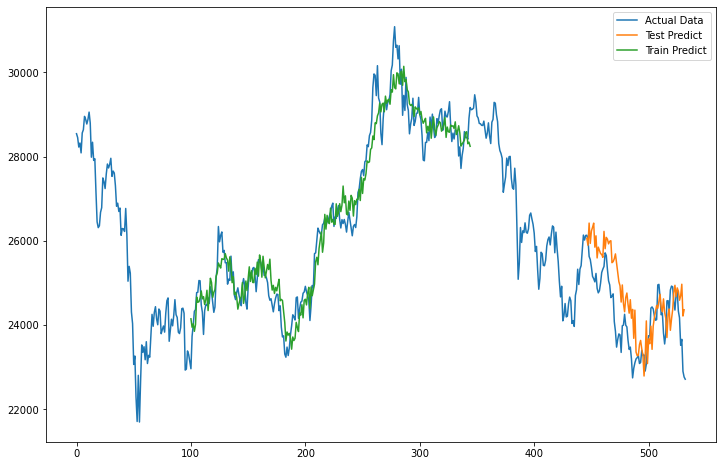

In [293]:
look_back=time_step
trainPredictPlot=np.empty_like(data)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

testPredictPlot=np.empty_like(data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1,:] = test_predict

plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)
plt.legend(['Actual Data','Test Predict','Train Predict'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

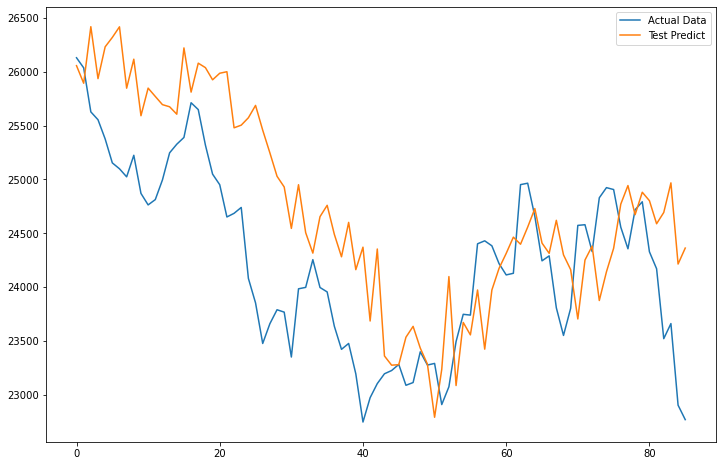

In [294]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data)[len(train_predict)+(look_back*2)+1:len(data)-1])
plt.plot(test_predict)
plt.legend(['Actual Data','Test Predict'])
plt.show

### Evaluation

In [295]:
from sklearn.metrics import mean_squared_error
test_predict=readout.predict(input_repr_te)
print('MSE:',mean_squared_error(y_test, test_predict))

MSE: 0.00780808908210334


In [296]:
print('Coefficient of Variation:',df.std()/df.mean())

Coefficient of Variation: 0.07806577112815868


In [297]:
print('Time taken for training in seconds:',end-start)

Time taken for training in seconds: 4.835643768310547
